# Defining basis functions

In this notebook we will define a basis function that we will later use to train a performance model. A basis function takes a score as input, and returns an array where each row corresponds to a note in the score, and each column corresponds to some descriptor defined by the basis function. There may be just a single descriptor per basis function, or several.

We will define a very simple basis function that has a single descriptor, namely the MIDI pitch of the notes. 

To test our basis function we need a score, so let's start by calling `init_dataset()` from the `data` module. This ensures we have a local copy of the vienna4x22 corpus.

In [1]:
%matplotlib notebook
from helper import init_dataset, data

init_dataset() # download the corpus if necessary; set some variables

Output()

After the data has been downloaded `init()` sets a couple of global variables that make it easier to access the data. For now we want just a  MusicXML file from the corpus so we can define a basis function and test it on the file. `data.SCORE_PERFORMANCE_PAIRS` holds a list of MusicXML/Match filename pairs, so let's grab the first pair:

In [2]:
xml_fn, match_fn = data.SCORE_PERFORMANCE_PAIRS[0]
print(xml_fn)

/home/matthias/.cache/basismixer/OFAI-vienna4x22_rematched-7b60448/musicxml/Chopin_op10_no3.musicxml


It's Chopin's Etude Opus 10 number 3. We also got a match file for some performance of the piece (stored in `match_fn`) but we don't need it for the basis function.

Let's load the score into Python using the [partitura](https://github.com/OFAI/partitura) package:

In [3]:
import partitura

part = partitura.load_musicxml(xml_fn)
print(part)

Part id="P1" name="Chopin_op10_no3"


The `Part` object contains the musical elements that are defined in the MusicXML file, such as notes, measures, performance directions, and slurs. You can read more in the [online documentation](https://partitura.readthedocs.io/en/latest/index.html). For now let's start with some basics.

Through the attribute [notes](https://partitura.readthedocs.io/en/latest/modules/partitura.score.html#partitura.score.Part.notes) you get a list of all the notes in the piece. Let's count the number of notes:

In [4]:
len(part.notes)

498

There are 498 notes in this part. However, some notes in the score are [tied](https://en.wikipedia.org/wiki/Tie_(music)). That means that they are encoded as separate notes in the score, but they should sound as a single note. In the context of expression modeling, we want to treat tied notes as a single note. The attribute [notes_tied](https://partitura.readthedocs.io/en/latest/modules/partitura.score.html#partitura.score.Part.notes_tied) does just that:

In [5]:
len(part.notes_tied)

486

Now there are 486 notes, that means that some notes in the score were indeed tied.

We are now ready to define our MIDI pitch basis function. All we need to do is to define a function, say `midi_pitch_basis`, that takes the part object, and returns the following: a `N` x 1 numpy array where `N` equals `len(part.notes_tied)`, and column names of the array:

In [6]:
import numpy as np

def midi_pitch_basis(part):
    # the list of descriptors
    names = ['pitch']
    # the N midi pitches
    basis = np.array([n.midi_pitch for n in part.notes_tied])
    # we need an N x 1 array, so we reshape
    basis = basis.reshape((-1, 1))
    # finally we normalize the so the values are between 0 and 1
    basis = basis/127.
    return basis, names

We create the midi pitch basis function for a part like this:

In [7]:
basis, names = midi_pitch_basis(part)

The function `plot_basis` shows the values of basis function over the course of the piece:

<IPython.core.display.Javascript object>


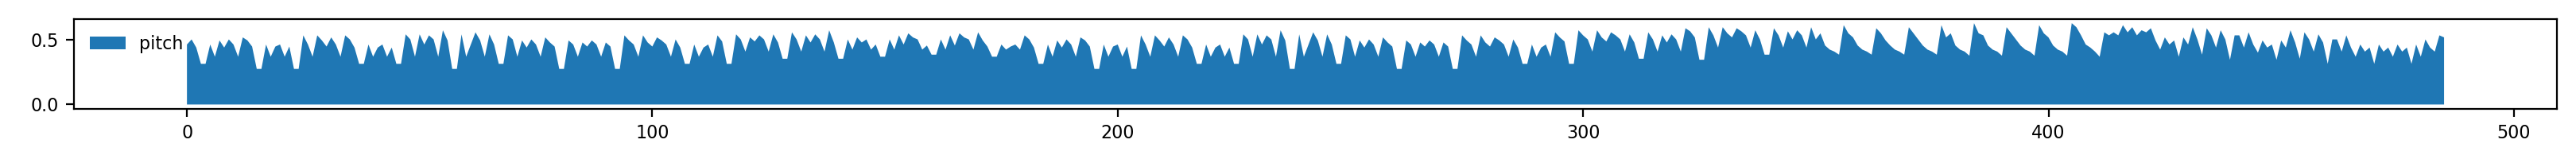

In [8]:
from helper import plot_basis

plot_basis(basis, names)

Let's define another basis function that encodes the number of notes starting simultaneously:

In [9]:
import numpy as np
import partitura

def n_sim_notes_basis(part):
    # the list of descriptors
    names = ['simultaneous_notes']
    # notes
    notes = part.notes_tied
    
    basis = np.array([len(n.start.starting_objects[partitura.score.Note])
                      for n in part.notes_tied])
    # we need an N x 1 array, so we reshape
    basis = basis.reshape((-1, 1))

    return basis, names


<IPython.core.display.Javascript object>


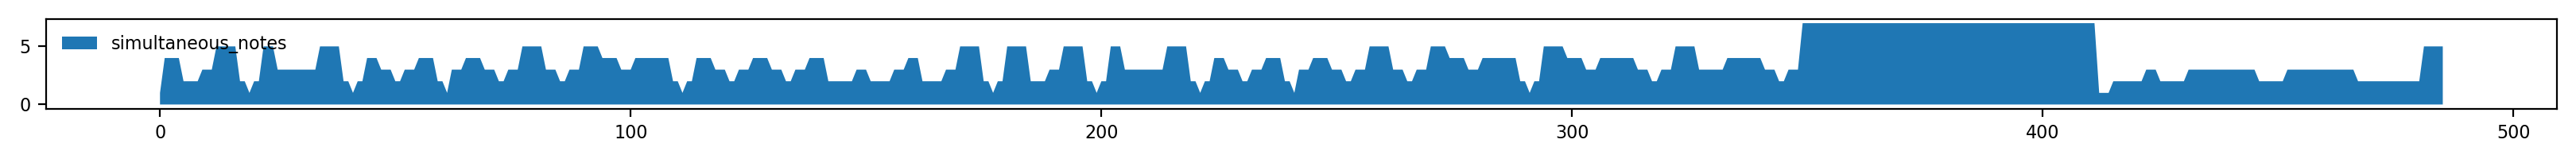

In [10]:
basis, names = n_sim_notes_basis(part)

plot_basis(basis, names)

Once we have defined one or more basis we can compute them all together for a part using the `make_basis` function:

In [11]:
from basismixer.basisfunctions import make_basis

basis, names = make_basis(part, [n_sim_notes_basis, midi_pitch_basis])
print(names)

['n_sim_notes_basis.simultaneous_notes', 'midi_pitch_basis.pitch']


The basismixer package comes with a number of predefined basis functions. You can print an overview of the available basis functions using `print_basis_functions`:

In [12]:
from basismixer.basisfunctions import print_basis_functions
print_basis_functions()

* articulation_basis
    Articulation basis.    
    
    This basis returns articulation-related note annotations, such as accents, legato, and tenuto.    
    
    Possible descriptors:    
    * accent : 1 when the note has an annotated accent sign    
    * legato : 1 when the note has an annotated legato sign    
    * staccato : 1 when the note has an annotated staccato sign    
    ...    
    
    
* articulation_direction_basis
        
    
* duration_basis
    Duration basis.    
    
    Returns:    
    * duration : the duration of the note    
    
    
* fermata_basis
    Fermata basis.    
    
    Returns:    
    * fermata : 1 when the note coincides with a fermata sign.    
    
    
* grace_basis
    Grace basis.    
    
    Returns:    
    * grace_note : 1 when the note is a grace note, 0 otherwise    
    * n_grace : the length of the grace note sequence to which     
                this note belongs (0 for non-grace notes)    
    * grace_pos : the (1-based) p